In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
from scipy.stats import skew, kurtosis

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [4]:
plt.style.use("D:/Neural Data Science/CL6/CL1/matplotlib_style.txt")

In [5]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [6]:
# META DATA

meta = pd.read_csv(
    "D:/Neural Data Science/CL6/project/data/m1_patchseq_meta_data.csv",
    sep="\t",
)

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


#### Madhavi:
Data preprocessing and analysis pipeline for neural data, involving loading metadata, cleaning data, setting up paths, and performing consistency checks. It also prepares for visualization with a specific matplotlib style and ensures reproducibility of results by setting a random seed.

### Transcriptomic data

In [7]:
# READ COUNTS

data_exons = pd.read_csv(
    "D:/Neural Data Science/CL6/project/data/m1_patchseq_exon_counts.csv.gz",
    na_filter=False,
    index_col=0,
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


#### Madhavi
Reads exon count data from a compressed CSV file, transposes the data for proper orientation, ensures consistency with cell names from the metadata, and extracts gene names. It prepares the data for further analysis, likely involving gene expression analysis or machine learning tasks in the context of neural data science.

In [8]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# GENE LENGTH

data = pd.read_csv("D:/Neural Data Science/CL6/project/data/gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

#### Madhavi:
This part of the code ensures the integrity of gene length data by verifying the gene IDs match those from the exon count data (genes). It then extracts exon and intron lengths from the gene length dataset, preparing these values for use in subsequent analyses. This type of data is crucial for understanding gene structure and potentially correlating it with gene expression levels or other biological characteristics in neural data science research.

### Cluster colors

In [10]:
cluster_colors = np.load(
    "D:/Neural Data Science/CL6/project/data/cluster_colors.npy"
)

In [11]:
cluster_colors.shape

(1329,)

In [12]:
rna_type = np.load(
    "D:/Neural Data Science/CL6/project/data/rna_type.npy", allow_pickle=True
)

In [13]:
rna_type.shape

(1329,)

#### Madhavi:
Loading data from NumPy .npy files

In [14]:
pickle_in = open(
    "D:/Neural Data Science/CL6/project/data/dict_rna_type_colors.pkl", "rb"
)
dict_rna_type_colors = pickle.load(pickle_in)

In [15]:
len(dict_rna_type_colors)

88

#### Madhavi:
Retrieve and load a pre-saved dictionary (dict_rna_type_colors) from a pickle file. The loaded dictionary likely contains mappings between RNA types and corresponding colors, which could be used for visualizing or categorizing RNA data in neural data science analyses.

### Electrophysiological features

In [16]:
# EPHYS DATA

ephysData = pd.read_csv(
    "D:/Neural Data Science/CL6/project/data/m1_patchseq_ephys_features.csv"
)
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


#### Madhavi:
Reads ephys data from a CSV file, processes it by mapping cell IDs to their respective ephys measurements, and aligns this data with a predefined list of cells (cells).

In [17]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [18]:
np.sum(np.isnan(ephysData_filtered))

0

#### Madhavi:
- Excludes specified features (features_exclude).
- Applies logarithmic transformation to specified features (features_log).
- Removes rows with NaN values.
- Standardizes the data to have a mean of zero and a standard deviation of one.
- Checks for any remaining NaN values in the processed data (ephysData_filtered).

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

# Different Statistics 

## Statistics for the Transcriptomics Data

In [19]:
# Compute basic statistics on exonCounts
exon_mean = np.mean(exonCounts, axis=0)
exon_std = np.std(exonCounts, axis=0)
exon_min = np.min(exonCounts, axis=0)
exon_max = np.max(exonCounts, axis=0)
exon_median = np.median(exonCounts, axis=0)
exon_q25 = np.percentile(exonCounts, 25, axis=0)
exon_q75 = np.percentile(exonCounts, 75, axis=0)
exon_skewness = skew(exonCounts, axis=0)
exon_kurtosis = kurtosis(exonCounts, axis=0)

# Print or inspect these statistics
print("Exon Counts Statistics:")
print(f"Mean: {exon_mean}")
print(f"Standard Deviation: {exon_std}")
print(f"Minimum: {exon_min}")
print(f"Maximum: {exon_max}")
print(f"Median: {exon_median}")
print(f"25th Percentile: {exon_q25}")
print(f"75th Percentile: {exon_q75}")
print(f"Skewness: {exon_skewness}")
print(f"Kurtosis: {exon_kurtosis}")

Exon Counts Statistics:
Mean: [9.03686983e-01 1.05342363e-02 4.18216704e+01 ... 1.55756208e-01
 1.05342363e-02 7.52445448e-03]
Standard Deviation: [  5.53555251   0.35749791 125.62056265 ...   2.06602064   0.16424697
   0.20143345]
Minimum: [0 0 0 ... 0 0 0]
Maximum: [  86   13 2652 ...   57    3    7]
Median: [0. 0. 0. ... 0. 0. 0.]
25th Percentile: [0. 0. 0. ... 0. 0. 0.]
75th Percentile: [ 0.  0. 20. ...  0.  0.  0.]
Skewness: [ 8.63102027 36.10937537  9.52819066 ... 19.65653303 16.44946082
 32.29369397]
Kurtosis: [  88.36382008 1308.47727326  156.76383893 ...  468.90031251  278.11629023
 1097.27483474]


## Statistics for the Electrophysiological Data

In [20]:
# Compute basic statistics on ephysData_filtered
ephys_mean = np.mean(ephysData_filtered, axis=0)
ephys_std = np.std(ephysData_filtered, axis=0)
ephys_min = np.min(ephysData_filtered, axis=0)
ephys_max = np.max(ephysData_filtered, axis=0)
ephys_median = np.median(ephysData_filtered, axis=0)
ephys_q25 = np.percentile(ephysData_filtered, 25, axis=0)
ephys_q75 = np.percentile(ephysData_filtered, 75, axis=0)
ephys_skewness = skew(ephysData_filtered, axis=0)
ephys_kurtosis = kurtosis(ephysData_filtered, axis=0)

# Print or inspect these statistics
print("\nElectrophysiological Data Statistics:")
print(f"Mean: {ephys_mean}")
print(f"Standard Deviation: {ephys_std}")
print(f"Minimum: {ephys_min}")
print(f"Maximum: {ephys_max}")
print(f"Median: {ephys_median}")
print(f"25th Percentile: {ephys_q25}")
print(f"75th Percentile: {ephys_q75}")
print(f"Skewness: {ephys_skewness}")
print(f"Kurtosis: {ephys_kurtosis}")

# You can compute other statistics as needed for specific features.


Electrophysiological Data Statistics:
Mean: [-4.90348503e-16  7.80358522e-15 -1.55523216e-15 -3.54093859e-16
 -1.43201949e-15  1.83896459e-16  1.21711353e-15  1.73110684e-15
 -4.13011376e-15  2.36443861e-15 -1.25152414e-16 -3.27381220e-15
  8.41078049e-17 -1.49219862e-15  1.03713334e-15 -4.71272852e-15
 -1.59720721e-15]
Standard Deviation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Minimum: [-3.69736261 -4.27104422 -4.03308767 -4.00534968 -1.73191602 -2.47766687
 -2.93977985 -3.08985515 -1.55642393 -3.11324113 -1.19109947 -1.54800635
 -0.87085593 -3.9949949  -1.22975263 -1.16822945 -1.48033622]
Maximum: [2.40104089 1.7899558  3.12875355 3.59931221 3.36191409 2.83341748
 6.27835376 3.38244429 5.83677553 2.36483979 3.86708165 5.56371932
 5.10613943 2.90428911 5.04336828 5.35640862 3.262664  ]
Median: [ 0.13702179  0.33584456  0.05561223 -0.01432906 -0.18557474  0.04772477
 -0.2798632   0.12863401 -0.19959366  0.11684322 -0.34806928 -0.27794397
 -0.36111883  0.00294271 -0.37432

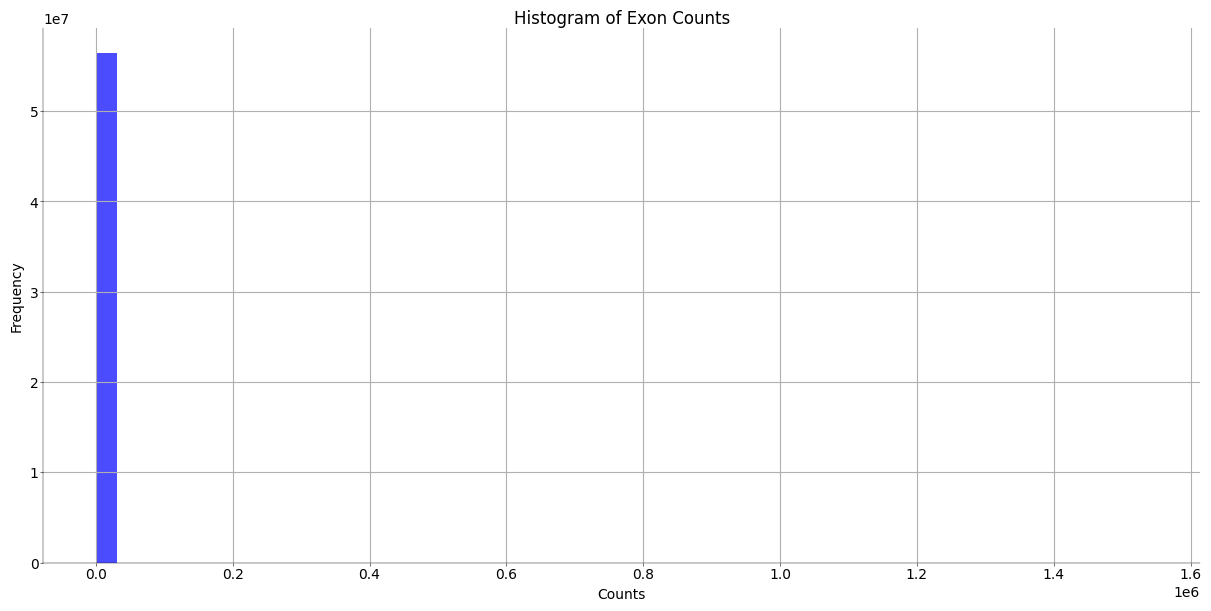

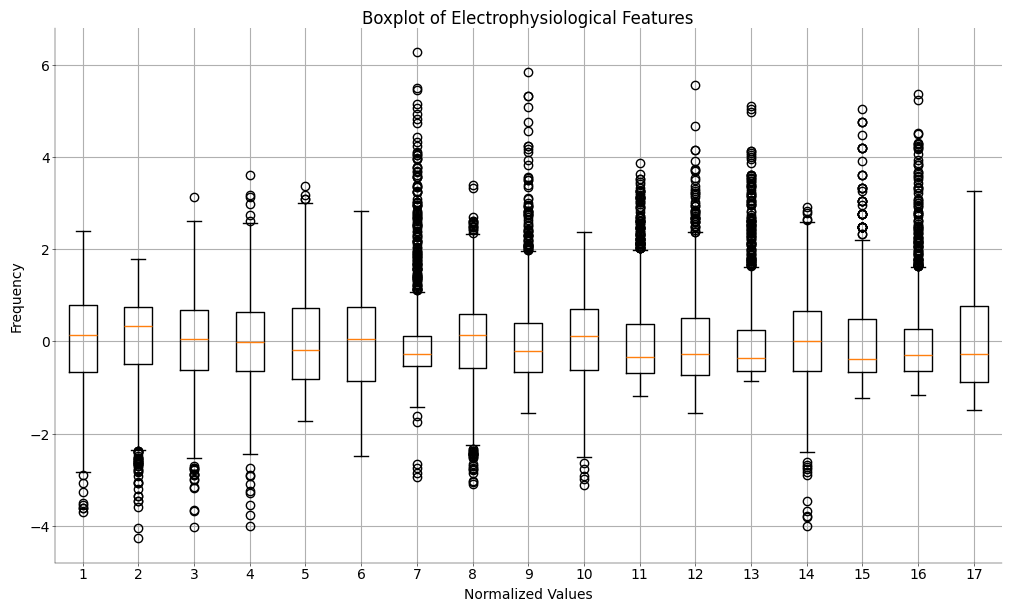

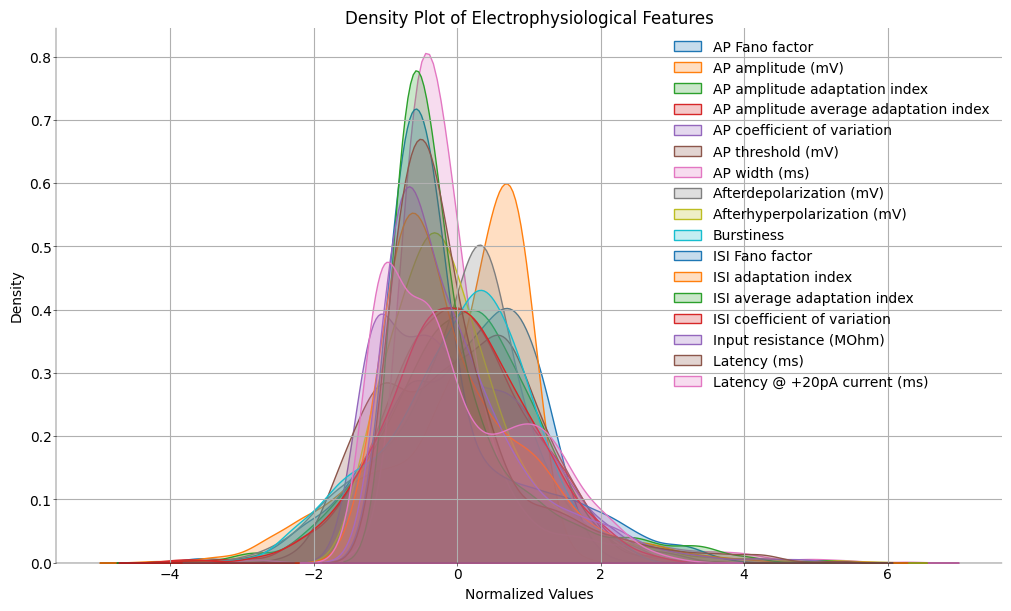

In [21]:
# Enable inline plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Histograms for Exon Counts
plt.figure(figsize=(12, 6))
plt.hist(exonCounts.flatten(), bins=50, color="blue", alpha=0.7)
plt.title("Histogram of Exon Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Boxplot for Electrophysiological Data
plt.figure(figsize=(10, 6))
plt.boxplot(ephysData_filtered)
plt.title("Boxplot of Electrophysiological Features")
plt.xlabel("Normalized Values")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Density Plot for Electrophysiological Data
plt.figure(figsize=(10, 6))
for i in range(ephysData_filtered.shape[1]):
    sns.kdeplot(ephysData_filtered[:, i], label=ephysNames[i], fill=True)
plt.title("Density Plot of Electrophysiological Features")
plt.xlabel("Normalized Values")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## Normalizing Electrophysiological Data

In [22]:
# Summary statistics for electrophysiological features
mean_ephys = np.mean(ephysData_filtered, axis=0)
median_ephys = np.median(ephysData_filtered, axis=0)
variance_ephys = np.var(ephysData_filtered, axis=0)
std_dev_ephys = np.std(ephysData_filtered, axis=0)

# Normality test (Shapiro-Wilk test) for each feature
shapiro_tests_ephys = [
    stats.shapiro(ephysData_filtered[:, i])
    for i in range(ephysData_filtered.shape[1])
]

# Display results
print("\nElectrophysiological Features Summary Statistics:")
for i, name in enumerate(ephysNames):
    if i < len(mean_ephys):
        print(f"{name}:")
        print(f"  Mean: {mean_ephys[i]}")
        print(f"  Median: {median_ephys[i]}")
        print(f"  Variance: {variance_ephys[i]}")
        print(f"  Standard Deviation: {std_dev_ephys[i]}")
        print(
            f"  Shapiro-Wilk Test: Statistic={shapiro_tests_ephys[i].statistic}, p-value={shapiro_tests_ephys[i].pvalue}"
        )

NameError: name 'stats' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
)

# Ensure all values are strictly positive for Box-Cox by adding a constant
constant = np.abs(np.min(ephysData_filtered)) + 1e-6

# Normalize the filtered data
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

ephysData_min_max_scaled = min_max_scaler.fit_transform(ephysData_filtered)
ephysData_standard_scaled = standard_scaler.fit_transform(ephysData_filtered)

# Ensure ephysNames has the same number of elements as the number of columns in ephysData_filtered
ephysNames_filtered = ephysNames[~np.isin(ephysNames, features_exclude)]


def apply_transformation(data, names, transform_func, transform_name):
    transformed_data = transform_func(data)
    shapiro_results = [
        stats.shapiro(transformed_data[:, i])
        for i in range(transformed_data.shape[1])
    ]

    return transformed_data


# Box-Cox Transformation
boxcox_transformer = PowerTransformer(method="box-cox")
if np.all(ephysData_filtered + constant > 0):
    ephysData_boxcox_transformed = apply_transformation(
        ephysData_filtered + constant,
        ephysNames_filtered,
        boxcox_transformer.fit_transform,
        "Box-Cox Transformed",
    )

# Yeo-Johnson Transformation
yeojohnson_transformer = PowerTransformer(method="yeo-johnson")
ephysData_yeojohnson_transformed = apply_transformation(
    ephysData_filtered,
    ephysNames_filtered,
    yeojohnson_transformer.fit_transform,
    "Yeo-Johnson Transformed",
)

In [ ]:
# Function to print summary statistics for normalized data
def print_summary_statistics(data, names, method):
    mean = np.mean(data, axis=0)
    median = np.median(data, axis=0)
    variance = np.var(data, axis=0)
    std_dev = np.std(data, axis=0)

    print(f"\n{method} Summary Statistics:")
    for i, name in enumerate(names):
        print(f"{name}:")
        print(f"  Mean: {mean[i]}")
        print(f"  Median: {median[i]}")
        print(f"  Variance: {variance[i]}")
        print(f"  Standard Deviation: {std_dev[i]}")


# Print summary statistics for Min-Max Scaled data
print_summary_statistics(
    ephysData_min_max_scaled, ephysNames_filtered, "Min-Max Scaled"
)

# Print summary statistics for Z-score Normalized data
print_summary_statistics(
    ephysData_standard_scaled, ephysNames_filtered, "Z-score Normalized"
)

# Print summary statistics for Box-Cox Transformed data
if np.all(ephysData_filtered + constant > 0):
    print_summary_statistics(
        ephysData_boxcox_transformed,
        ephysNames_filtered,
        "Box-Cox Transformed",
    )

# Print summary statistics for Yeo-Johnson Transformed data
print_summary_statistics(
    ephysData_yeojohnson_transformed,
    ephysNames_filtered,
    "Yeo-Johnson Transformed",
)


Min-Max Scaled Summary Statistics:
AP amplitude (mV):
  Mean: 0.6062836950817737
  Median: 0.6287521639685558
  Variance: 0.026888568819823565
  Standard Deviation: 0.16397734239773362
AP amplitude adaptation index:
  Mean: 0.7046764901330673
  Median: 0.7600872405655147
  Variance: 0.02722146092242837
  Standard Deviation: 0.164989275173959
AP coefficient of variation:
  Mean: 0.5631355880479443
  Median: 0.5709006619910559
  Variance: 0.019496229283824083
  Standard Deviation: 0.1396288984552413
AP threshold (mV):
  Mean: 0.5266966158628565
  Median: 0.5248123691342302
  Variance: 0.01729179908429168
  Standard Deviation: 0.13149828548042625
AP width (ms):
  Mean: 0.34000270562770707
  Median: 0.3035714285714358
  Variance: 0.03853994472057081
  Standard Deviation: 0.19631593088837904
Afterhyperpolarization (mV):
  Mean: 0.46650866493559584
  Median: 0.4754945451133724
  Variance: 0.03545141720538824
  Standard Deviation: 0.18828546732392343
ISI adaptation index:
  Mean: 0.318912697

In [ ]:
def shapiro_wilk_pvalues(data, names):
    pvalues = {}

    # Shapiro-Wilk p-values for Min-Max Scaled data
    min_max_scaled_pvalues = [
        stats.shapiro(data[:, i])[1] for i in range(data.shape[1])
    ]
    pvalues["Min-Max Scaled"] = dict(zip(names, min_max_scaled_pvalues))

    # Shapiro-Wilk p-values for Z-score Normalized data
    standard_scaled_pvalues = [
        stats.shapiro(ephysData_standard_scaled[:, i])[1]
        for i in range(ephysData_standard_scaled.shape[1])
    ]
    pvalues["Z-score Normalized"] = dict(zip(names, standard_scaled_pvalues))

    # Shapiro-Wilk p-values for Box-Cox Transformed data
    boxcox_transformed_pvalues = [
        stats.shapiro(ephysData_boxcox_transformed[:, i])[1]
        for i in range(ephysData_boxcox_transformed.shape[1])
    ]
    pvalues["Box-Cox Transformed"] = dict(
        zip(names, boxcox_transformed_pvalues)
    )

    # Shapiro-Wilk p-values for Yeo-Johnson Transformed data
    yeojohnson_transformed_pvalues = [
        stats.shapiro(ephysData_yeojohnson_transformed[:, i])[1]
        for i in range(ephysData_yeojohnson_transformed.shape[1])
    ]
    pvalues["Yeo-Johnson Transformed"] = dict(
        zip(names, yeojohnson_transformed_pvalues)
    )

    return pvalues


# Compute Shapiro-Wilk p-values for each transformation method
shapiro_wilk_pvalues = shapiro_wilk_pvalues(
    ephysData_filtered, ephysNames_filtered
)

# Display Shapiro-Wilk p-values for each transformation method
for method, pvalues in shapiro_wilk_pvalues.items():
    print(f"\nShapiro-Wilk p-values for {method} Data:")
    for name, pvalue in pvalues.items():
        print(f"{name}: {pvalue}")


Shapiro-Wilk p-values for Min-Max Scaled Data:
AP amplitude (mV): 7.14001159477085e-16
AP amplitude adaptation index: 1.3535967950059206e-29
AP coefficient of variation: 8.687188760657883e-06
AP threshold (mV): 0.016207086038013154
AP width (ms): 4.603152087336495e-20
Afterhyperpolarization (mV): 2.4342186845553347e-09
ISI adaptation index: 5.126433846441085e-42
ISI coefficient of variation: 7.713704132711185e-10
Input resistance (MOhm): 2.707807294852655e-30
Latency (ms): 6.050556169660313e-09
Max number of APs: 1.8332492121942316e-35
Membrane time constant (ms): 1.0389953116205725e-28
Rebound (mV): 6.644569613312615e-40
Resting membrane potential (mV): 0.0027942635083918446
Rheobase (pA): 2.3406538108879356e-33
Sag ratio: 1.2169148599907635e-37
Upstroke-to-downstroke ratio: 4.462081314266714e-25

Shapiro-Wilk p-values for Z-score Normalized Data:
AP amplitude (mV): 7.140011594767991e-16
AP amplitude adaptation index: 1.3535967950059206e-29
AP coefficient of variation: 8.687188760652

C:\Users\madha\AppData\Local\Temp\ipykernel_27520\4251960504.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


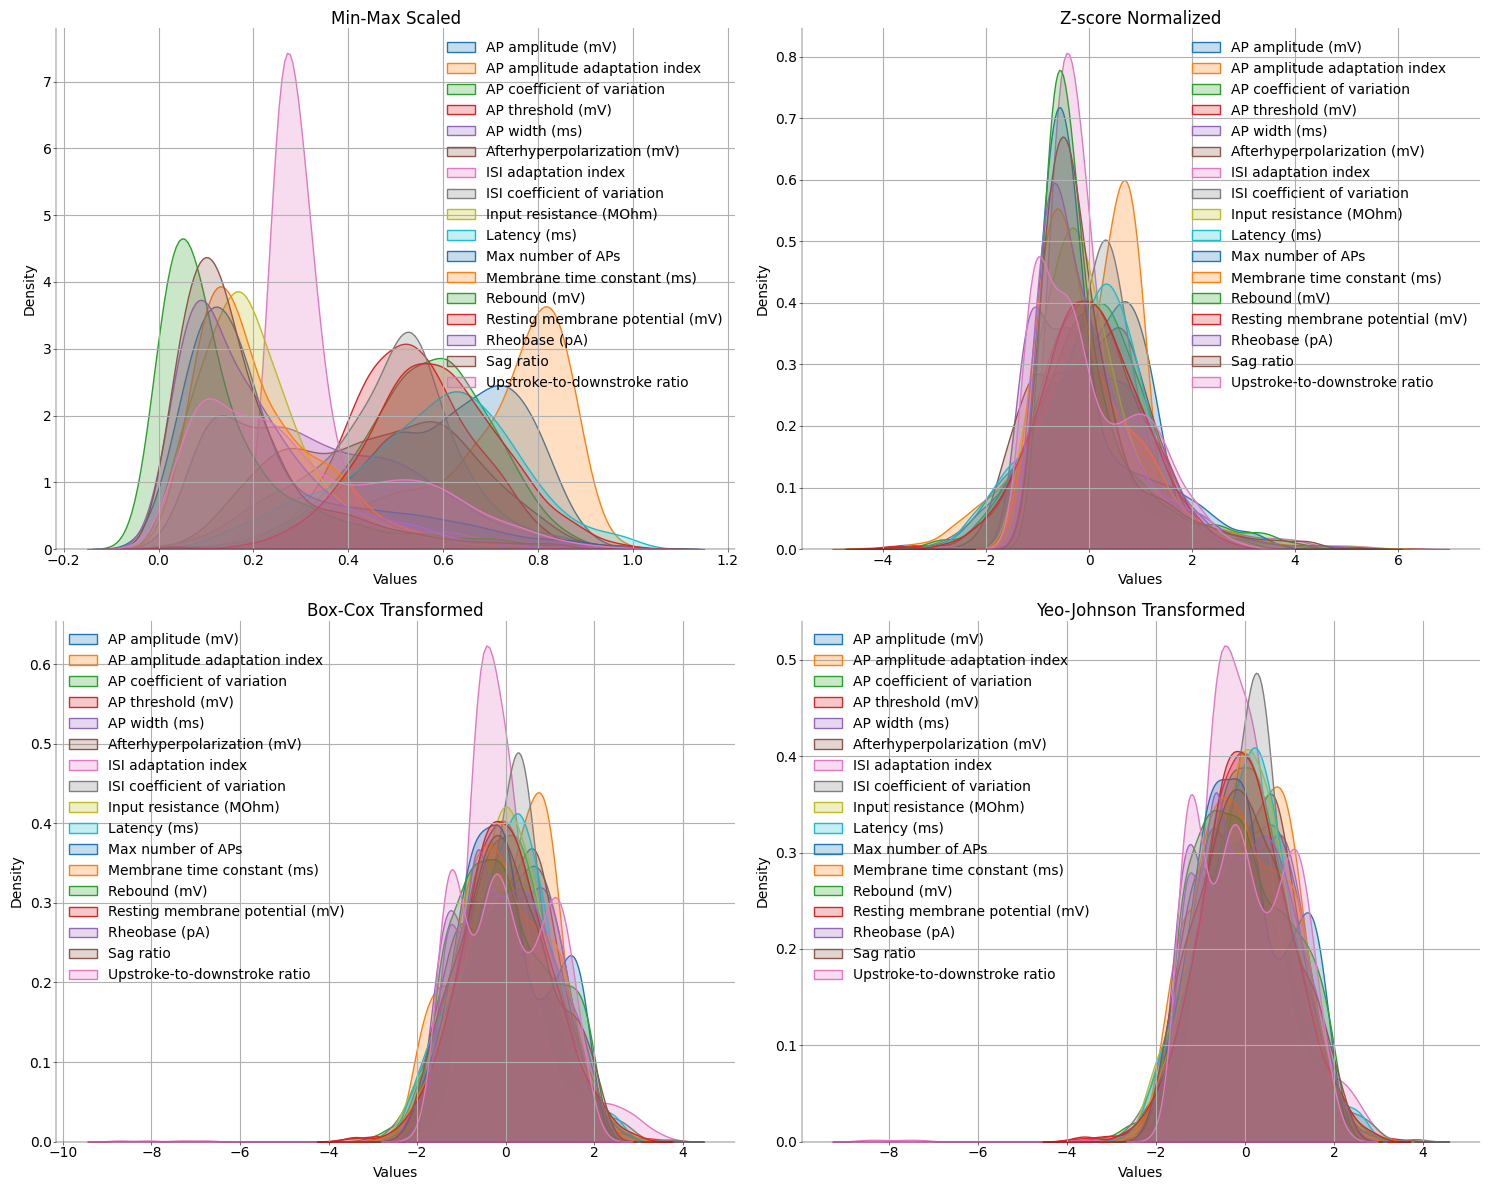

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
)

# Ensure all values are strictly positive for Box-Cox by adding a constant
constant = np.abs(np.min(ephysData_filtered)) + 1e-6

# Normalize the filtered data
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

ephysData_min_max_scaled = min_max_scaler.fit_transform(ephysData_filtered)
ephysData_standard_scaled = standard_scaler.fit_transform(ephysData_filtered)

# Box-Cox Transformation
boxcox_transformer = PowerTransformer(method="box-cox")
if np.all(ephysData_filtered + constant > 0):
    ephysData_boxcox_transformed = boxcox_transformer.fit_transform(
        ephysData_filtered + constant
    )

# Yeo-Johnson Transformation
yeojohnson_transformer = PowerTransformer(method="yeo-johnson")
ephysData_yeojohnson_transformed = yeojohnson_transformer.fit_transform(
    ephysData_filtered
)


# Function to plot density plots in a grid
def plot_density_grid(datasets, names, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for i, (data, name, title) in enumerate(zip(datasets, names, titles)):
        ax = axes[i // cols, i % cols]
        for j in range(data.shape[1]):
            sns.kdeplot(data[:, j], ax=ax, label=name[j], fill=True)
        ax.set_title(title)
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# Prepare data and titles for plotting
datasets = [
    ephysData_min_max_scaled,
    ephysData_standard_scaled,
    ephysData_boxcox_transformed,
    ephysData_yeojohnson_transformed,
]
names = [
    ephysNames_filtered,
    ephysNames_filtered,
    ephysNames_filtered,
    ephysNames_filtered,
]
titles = [
    "Min-Max Scaled",
    "Z-score Normalized",
    "Box-Cox Transformed",
    "Yeo-Johnson Transformed",
]

# Plot density plots in a 2x2 grid
plot_density_grid(datasets, names, titles, rows=2, cols=2)

In [ ]:
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Transpose the exonCounts matrix
exonCounts_transposed = exonCounts.transpose()


# Flatten the transposed exon counts
exonCounts_flat = exonCounts_transposed.flatten()
shapiro_test_exon = stats.shapiro(exonCounts_flat)
print(
    f"Shapiro-Wilk Test: Statistic={shapiro_test_exon.statistic}, p-value={shapiro_test_exon.pvalue}"
)


# Summary statistics function
def summary_statistics(data, name):
    mean = np.mean(data)
    median = np.median(data)
    variance = np.var(data)
    std_dev = np.std(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    shapiro_stat, shapiro_p = stats.shapiro(data)

    print(f"{name} Summary Statistics:")
    print(f"  Mean: {mean}")
    print(f"  Median: {median}")
    print(f"  Variance: {variance}")
    print(f"  Standard Deviation: {std_dev}")
    print(f"  Skewness: {skewness}")
    print(f"  Kurtosis: {kurtosis}")
    print(
        f"  Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}\n"
    )

Shapiro-Wilk Test: Statistic=0.01903121600931612, p-value=5.313797997915234e-217


c:\Users\madha\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 56437314.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# Compute and print summary statistics for exon counts
summary_statistics(exonCounts_flat, "Exon Counts")


# Apply transformations and re-evaluate normality
def apply_transformations(data):
    print("Original Data:")
    summary_statistics(data, "Exon Counts")

    # Log Transformation (Adding 1 to avoid log(0))
    log_transformed = np.log1p(data)
    print("Log Transformation:")
    summary_statistics(log_transformed, "Log Transformed Exon Counts")

    # Square Root Transformation
    sqrt_transformed = np.sqrt(data)
    print("Square Root Transformation:")
    summary_statistics(sqrt_transformed, "Square Root Transformed Exon Counts")

    # Box-Cox Transformation (data must be positive, adding 1 to avoid zero values)
    boxcox_transformed, _ = stats.boxcox(data + 1)
    print("Box-Cox Transformation:")
    summary_statistics(boxcox_transformed, "Box-Cox Transformed Exon Counts")

    # Yeo-Johnson Transformation
    power_transformer = PowerTransformer(method="yeo-johnson")
    yeo_johnson_transformed = power_transformer.fit_transform(
        data.reshape(-1, 1)
    ).flatten()
    print("Yeo-Johnson Transformation:")
    summary_statistics(
        yeo_johnson_transformed, "Yeo-Johnson Transformed Exon Counts"
    )

    # Min-Max Scaling
    scaler = MinMaxScaler()
    min_max_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    print("Min-Max Scaling:")
    summary_statistics(min_max_scaled, "Min-Max Scaled Exon Counts")

    return (
        log_transformed,
        sqrt_transformed,
        boxcox_transformed,
        yeo_johnson_transformed,
        min_max_scaled,
    )


# Apply transformations to exon counts
(
    log_transformed,
    sqrt_transformed,
    boxcox_transformed,
    yeo_johnson_transformed,
    min_max_scaled,
) = apply_transformations(exonCounts_flat)

c:\Users\madha\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 56437314.
  res = hypotest_fun_out(*samples, **kwds)


Exon Counts Summary Statistics:
  Mean: 37.739546127230646
  Median: 0.0
  Variance: 501734.5624948568
  Standard Deviation: 708.3322401916045
  Skewness: 585.6011839174737
  Kurtosis: 816592.560507063
  Shapiro-Wilk Test: Statistic=0.01903121600931612, p-value=5.313797997915234e-217

Original Data:
Exon Counts Summary Statistics:
  Mean: 37.739546127230646
  Median: 0.0
  Variance: 501734.5624948568
  Standard Deviation: 708.3322401916045
  Skewness: 585.6011839174737
  Kurtosis: 816592.560507063
  Shapiro-Wilk Test: Statistic=0.01903121600931612, p-value=5.313797997915234e-217

Log Transformation:
Log Transformed Exon Counts Summary Statistics:
  Mean: 0.5981905785484926
  Median: 0.0
  Variance: 2.504007059972279
  Standard Deviation: 1.582405466361981
  Skewness: 2.693278953381835
  Kurtosis: 6.216680162280609
  Shapiro-Wilk Test: Statistic=0.43345209138689345, p-value=2.784151824543252e-197

Square Root Transformation:
Square Root Transformed Exon Counts Summary Statistics:
  Mean

c:\Users\madha\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 56437314.
  res = hypotest_fun_out(*samples, **kwds)


Yeo-Johnson Transformed Exon Counts Summary Statistics:
  Mean: 1.5700166262382285e-16
  Median: -0.4319815573995708
  Variance: 1.0000000000000004
  Standard Deviation: 1.0000000000000002
  Skewness: 1.914863329487522
  Kurtosis: 1.7323965871286449
  Shapiro-Wilk Test: Statistic=0.4484490501349412, p-value=2.421218197649342e-196

Min-Max Scaling:
Min-Max Scaled Exon Counts Summary Statistics:
  Mean: 2.4556379905710277e-05
  Median: 0.0
  Variance: 2.1242682617062995e-07
  Standard Deviation: 0.0004608978478693841
  Skewness: 585.6011839174671
  Kurtosis: 816592.5605070661
  Shapiro-Wilk Test: Statistic=0.01903121600931612, p-value=5.313797997915234e-217



c:\Users\madha\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 56437314.
  res = hypotest_fun_out(*samples, **kwds)


In [23]:
# # Histograms and Q-Q Plots function
# def plot_histogram_qq(data, name):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.hist(data, bins=50, color="blue", alpha=0.7)
#     plt.title(f"Histogram of {name}")
#     plt.xlabel("Values")
#     plt.ylabel("Frequency")
#     plt.grid(True)

#     plt.subplot(1, 2, 2)
#     stats.probplot(data, dist="norm", plot=plt)
#     plt.title(f"Q-Q Plot of {name}")
#     plt.xlabel("Theoretical Quantiles")
#     plt.ylabel("Sample Quantiles")
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()


# # Plot histograms and Q-Q plots for original and transformed data
# plot_histogram_qq(exonCounts_flat, "Exon Counts")
# plot_histogram_qq(log_transformed, "Log Transformed Exon Counts")
# plot_histogram_qq(sqrt_transformed, "Square Root Transformed Exon Counts")
# plot_histogram_qq(boxcox_transformed, "Box-Cox Transformed Exon Counts")
# plot_histogram_qq(
#     yeo_johnson_transformed, "Yeo-Johnson Transformed Exon Counts"
# )
# plot_histogram_qq(min_max_scaled, "Min-Max Scaled Exon Counts")

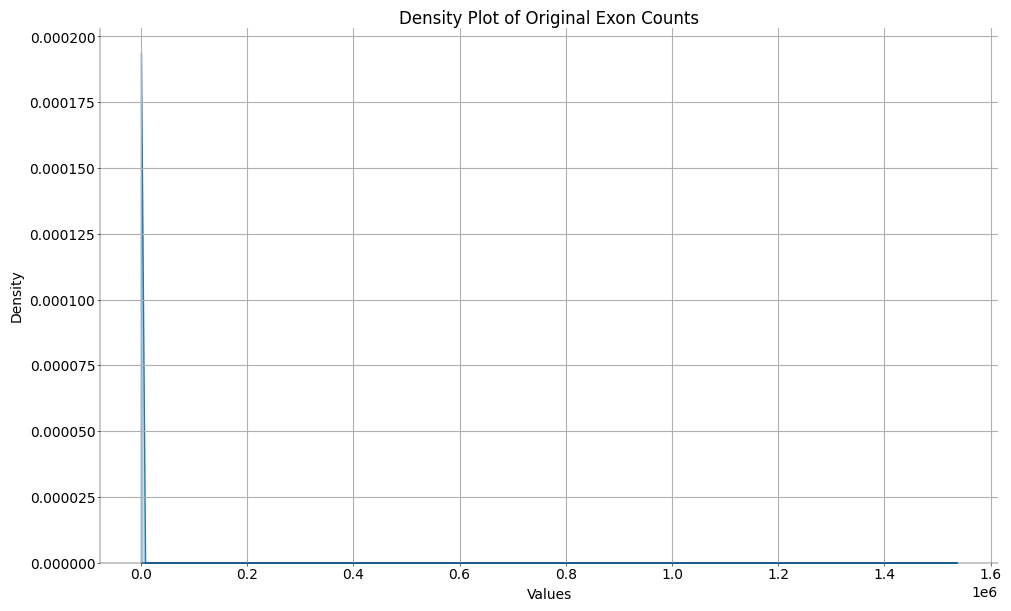

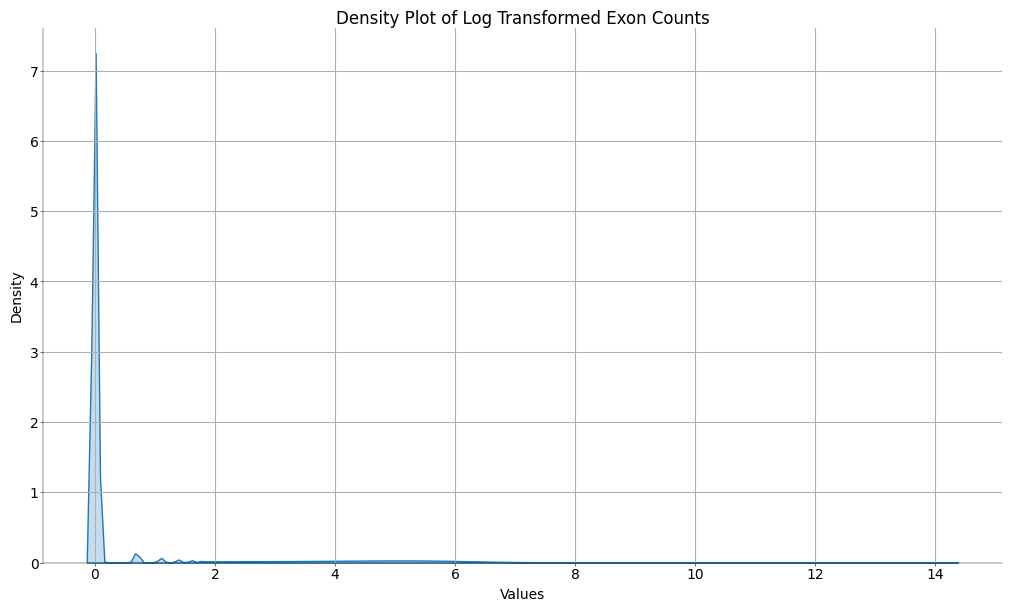

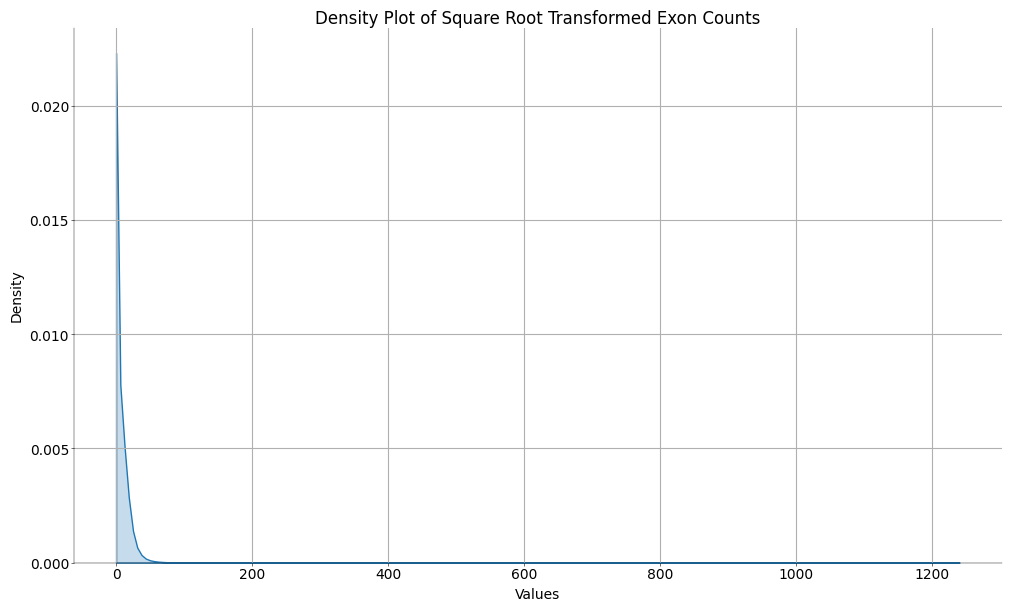

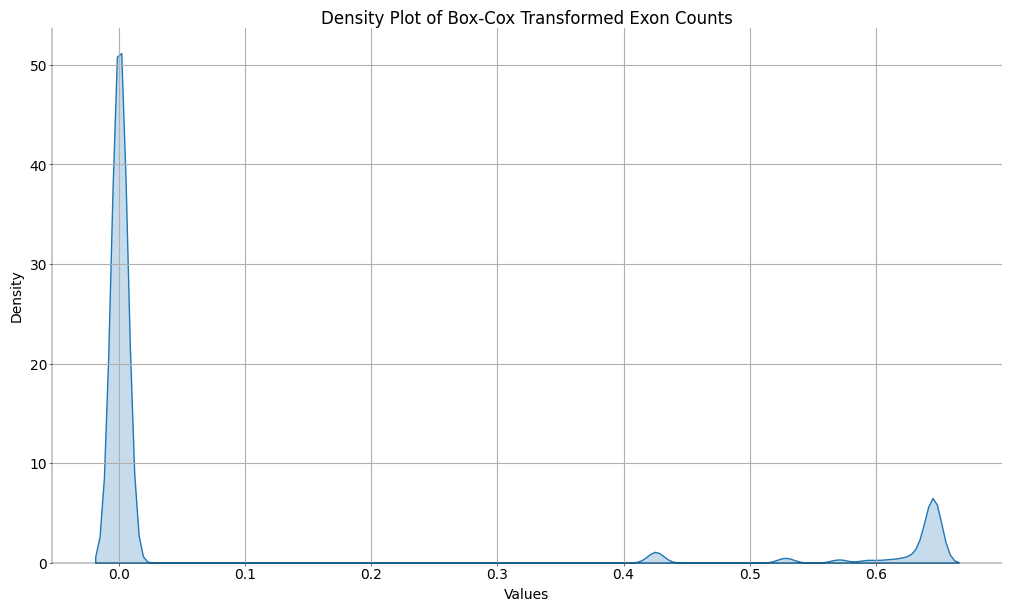

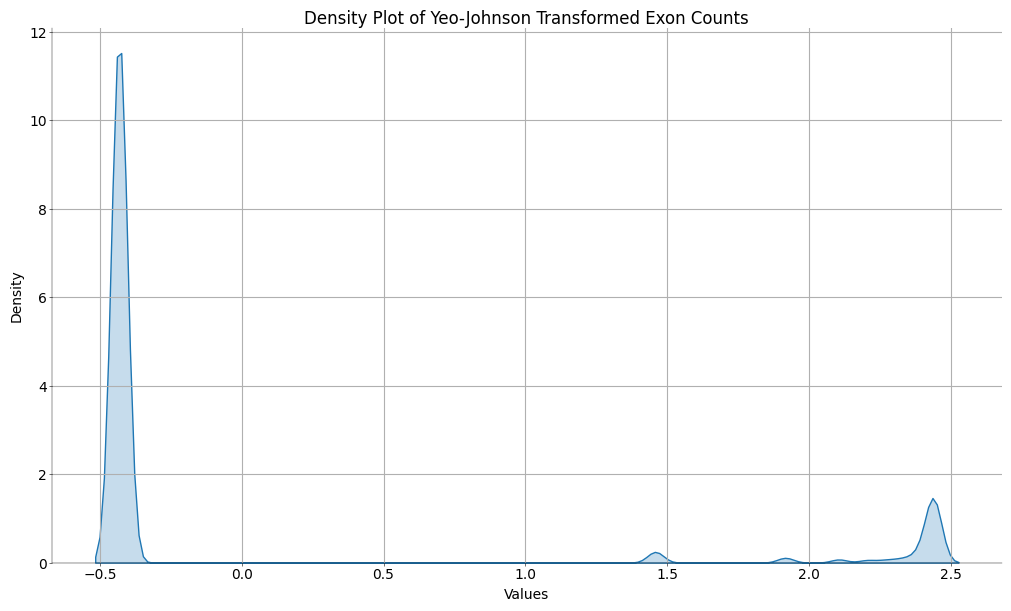

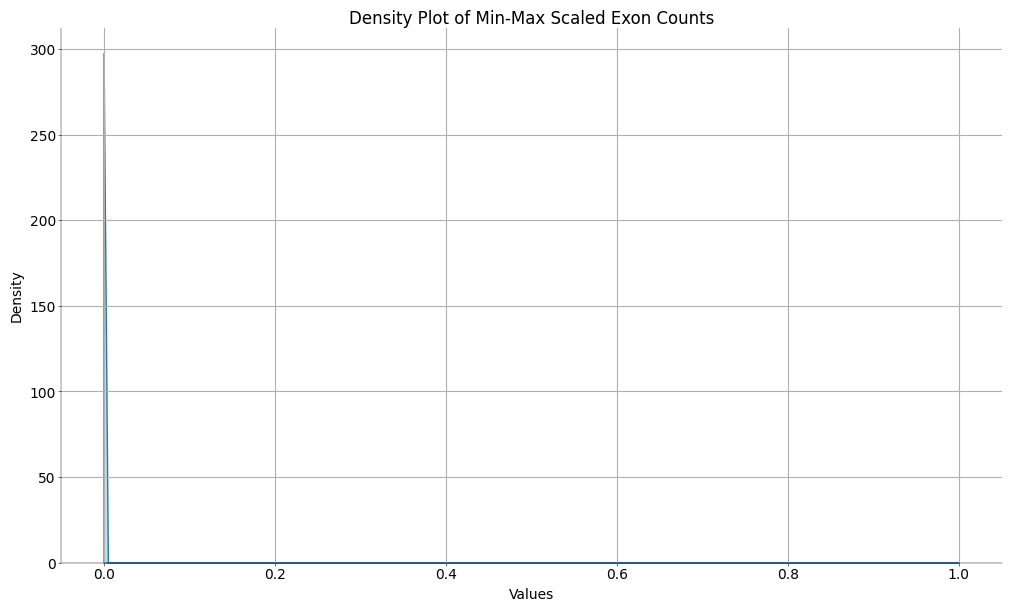

In [ ]:
# Density Plot for Transformed Exon Count Data
def plot_density(data, title):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data, fill=True)
    plt.title(f"Density Plot of {title}")
    plt.xlabel("Values")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


plot_density(exonCounts_flat, "Original Exon Counts")
plot_density(log_transformed, "Log Transformed Exon Counts")
plot_density(sqrt_transformed, "Square Root Transformed Exon Counts")
plot_density(boxcox_transformed, "Box-Cox Transformed Exon Counts")
plot_density(yeo_johnson_transformed, "Yeo-Johnson Transformed Exon Counts")
plot_density(min_max_scaled, "Min-Max Scaled Exon Counts")